In [13]:
import os, glob
import numpy as np
import xarray as xr
from enum import Enum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from glob import glob
import sys
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
sys.path.append('modules')
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import xarray_class_accessors as xca
from importlib import reload
import sn_plotting
import utils
from warnings import filterwarnings
filterwarnings('ignore')

In [37]:
import classes# import LocationsLatLon, ExperimentTypes

In [31]:
notebook_number = '04'
variable = 'pr'
window = 'window_101_length_1000'
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, variable)
ROOT_DIR_REGRID = os.path.join(ROOT_DIR, 'regrid_retimestamped')
ROOT_DIR_SN = os.path.join(ROOT_DIR, 'signal_to_noise',window)

In [7]:
models_to_get = open_ds.get_models_longer_than_length()
utils.pprint_list(models_to_get, num_start_items=7)

lenght = 7
 0. ccsm3
 1. cesm104
 2. cnrmcm61
 3. hadcm3l
 4. ipslcm5a
 5. mpiesm11
 6. mpiesm12


In [83]:
files_to_open_experiment = open_ds.get_file_names_from_from_directory(ROOT_DIR_REGRID,
                                                           classes.ExperimentTypes.ABRUPT4X,
                                                           models_to_get)

files_to_open_control = open_ds.get_file_names_from_from_directory(ROOT_DIR_REGRID,
                                                           classes.ExperimentTypes.CONTROL,
                                                           models_to_get)

utils.pprint_list(files_to_open_experiment)

lenght = 7
 0. pr_mon_CCSM3_abrupt4x_2120_g025.nc
 1. pr_mon_CESM104_abrupt4x_5900_g025.nc


In [95]:
files_to_open_signal_to_noise = open_ds.get_file_names_from_from_directory(ROOT_DIR_SN,
                                                           classes.ExperimentTypes.SIGNAL_TO_NOISE,
                                                          models_to_get)

files_to_open_signal_to_noise_stable =\
                        open_ds.get_file_names_from_from_directory(ROOT_DIR_SN,
                                               classes.ExperimentTypes.SIGNAL_TO_NOISE_STABLE,
                                              models_to_get)
utils.pprint_list(files_to_open_signal_to_noise)

- model='cesm104' - found_fname=None - No file found
- model='cesm104' - found_fname=None - No file found
lenght = 6
 0. signal_to_noise/ccsm3_signal_to_noise.nc
 1. signal_to_noise/cnrmcm61_signal_to_noise.nc


In [170]:
reload(open_ds)
sn_ds = open_ds.open_and_concat_nc_files(files_to_open_signal_to_noise, ROOT_DIR_SN, model_index=0)
sn_ds

Removing coords - ['variable']


<xarray.Dataset>
Dimensions:          (time: 1100, lon: 144, lat: 72, model: 6, variable: 1)
Coordinates:
  * time             (time) object 0001-12-31 00:00:00 ... 1100-12-31 00:00:00
  * lon              (lon) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * lat              (lat) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * model            (model) object 'ccsm3' 'cnrmcm61' ... 'mpiesm11' 'mpiesm12'
Dimensions without coordinates: variable
Data variables:
    signal_to_noise  (model, variable, time, lat, lon) float64 1.559 ... nan
    lower_bound      (model, variable, lat, lon) float64 -0.7634 ... -0.802
    upper_bound      (model, variable, lat, lon) float64 1.035 1.048 ... 0.9053

In [125]:
abrupt4x_ds = open_ds.read_and_merge_netcdfs(files_to_open_experiment, ROOT_DIR_REGRID)
control_ds = open_ds.read_and_merge_netcdfs(files_to_open_control, ROOT_DIR_REGRID)
# sn_ds = open_ds.read_and_merge_netcdfs(files_to_open_signal_to_noise,ROOT_DIR_SN, var='signal_to_noise')
# sn_ds

- model='cesm104' is too short has time_length=112 < requested_length=800
(fname='pr_mon_CESM104_abrupt4x_5900_g025.nc')


<xarray.Dataset>
Dimensions:   (time: 1100, variable: 1, lat: 72, lon: 144)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 1100-12-31 00:00:00
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * variable  (variable) object 'ccsm3'
Data variables:
    ccsm3     (variable, time, lat, lon) float64 ...
    cnrmcm61  (time, lat, lon) float64 ...
    hadcm3l   (time, lat, lon) float64 1.703 1.7 1.719 1.73 ... nan nan nan nan
    ipslcm5a  (time, lat, lon) float64 0.7063 0.6868 0.6756 ... nan nan nan
    mpiesm11  (time, lat, lon) float64 ...
    mpiesm12  (time, lat, lon) float64 1.254 1.273 1.306 1.329 ... nan nan nan
Attributes:
    length:   1100

In [126]:
# Anomalies
abrupt4x_anom_ds = abrupt4x_ds.clima_ds.anomalies(control_ds)

ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 

# Sinlge Point Plotting

In [88]:
lat,lon = LocationsLatLon.NEW_YORK.value
print(lat, lon)

40.7 74


In [89]:
'NEW_YORK'.replace('_', ' ').title()

'New York'

In [90]:
def plot_single_point_all_models(ds, location: LocationsLatLon, length =500, start=0,
                                ylabel=None, xlabel=None, ylim=None):
    lat,lon = location.value
    plt.style.use('seaborn-darkgrid')

    models = list(ds.data_vars)
    fig  = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    for model in models:
        da = (ds[model]
              .isel(time=slice(start, length))
              .sel(lat=lat, lon=lon, method='nearest')
             )
        da.plot(ax=ax, label=model)
    
    leg = ax.legend()
    ax.set_xlim(ds.time.values[start], ds.time.values[length])
    str_lat = str(lat) + 'N' if lat > 0 else str(lat) + 'S'
    str_lon = str(lon) +'E' if lon > 0 else str(lon) + 'W'
    location_name = location.name.replace('_', ' ').title()
    ax.set_title(f'{location_name}'  + r' ({}, {})'.format(str_lat, str_lon))
    
    if ylabel:
        ax.set_ylabel(ylabel)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylim:
        ax.set_ylim(ylim)
        
    return fig, ax

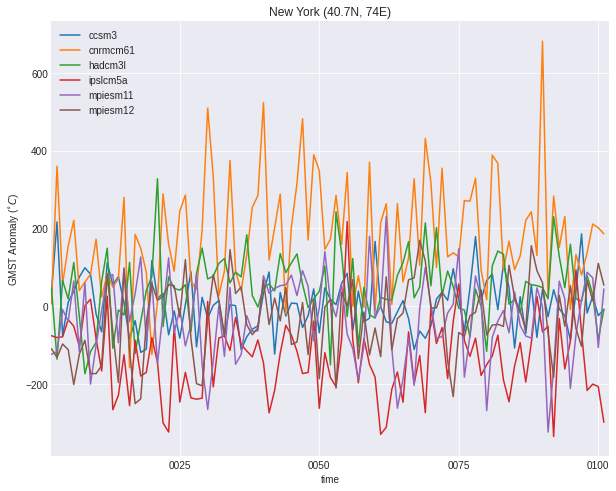

In [127]:
fig, ax = plot_single_point_all_models(abrupt4x_anom_ds, LocationsLatLon.NEW_YORK, length=100, 
                            ylabel=r'GMST Anomaly ($^{\circ}C$)')

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_{variable}_single_location_{LocationsLatLon.NEW_YORK.name}.png'),
           bbox_inches='tight')

In [128]:
# model_subset = ['gisse2r', 'ccsm3']
# fig, ax = plot_single_point_all_models(abrupt4x_anom_ds[model_subset], 
#                                        LocationsLatLon.NEW_YORK, length=100, ylim=(0, 8), 
#                             ylabel=r'GMST Anomaly ($^{\circ}C$)')

# fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
#                          f'07_single_location_{LocationsLatLon.NEW_YORK.name}_{model_subset}.png'),
#            bbox_inches='tight')

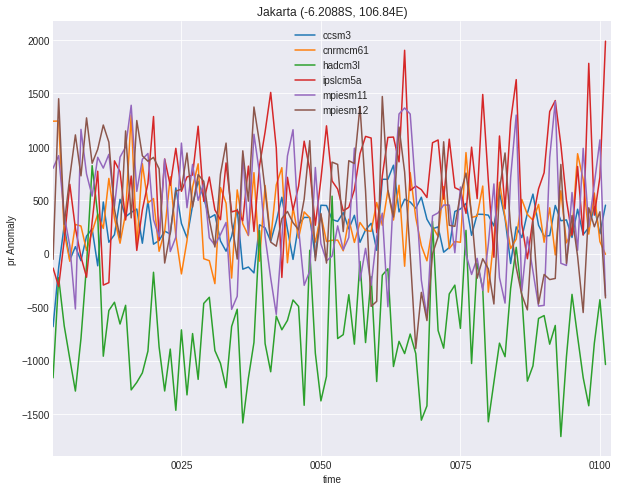

In [189]:
fig, ax = plot_single_point_all_models(abrupt4x_anom_ds, LocationsLatLon.JAKARTA, length=100, 
                            ylabel=f'{variable} Anomaly')


fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_{variable}_single_location_{LocationsLatLon.JAKARTA.name}.png'),
           bbox_inches='tight')

In [130]:
# Tas
# models_of_interst = ['GISSE2R', 'IPSLCM5A']

# model = models_of_interst[0]
# model

In [157]:
sn_ds

<xarray.Dataset>
Dimensions:   (time: 1100, variable: 1, lat: 72, lon: 144)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 1100-12-31 00:00:00
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * variable  (variable) object 'ccsm3'
Data variables:
    ccsm3     (variable, time, lat, lon) float64 ...
    cnrmcm61  (time, lat, lon) float64 ...
    hadcm3l   (time, lat, lon) float64 1.703 1.7 1.719 1.73 ... nan nan nan nan
    ipslcm5a  (time, lat, lon) float64 0.7063 0.6868 0.6756 ... nan nan nan
    mpiesm11  (time, lat, lon) float64 ...
    mpiesm12  (time, lat, lon) float64 1.254 1.273 1.306 1.329 ... nan nan nan
Attributes:
    length:   1100

In [181]:
models = list(abrupt4x_anom_ds.data_vars)
models

['ccsm3', 'cnrmcm61', 'hadcm3l', 'ipslcm5a', 'mpiesm11', 'mpiesm12']

In [182]:
model = models[0]
model

'ccsm3'

In [183]:
sn_da = sn_ds.sel(lat=lat, lon=lon, method='nearest').sel(model=model)['signal_to_noise']

abuprt_da = abrupt4x_anom_ds[model.lower()].sel(lat=lat, lon=lon, method='nearest')
abuprt_da = abuprt_da.where(abuprt_da.time.isin(sn_ds.time.values), drop =True)

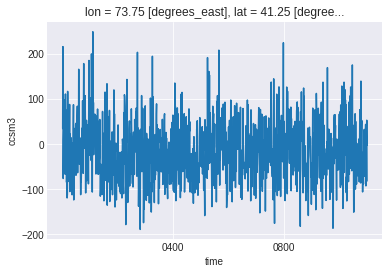

In [184]:
abuprt_da.plot()

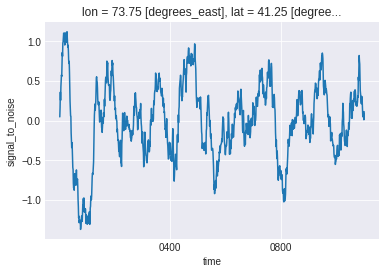

In [185]:
sn_da.squeeze().plot()

ValueError: x and y must have same first dimension, but have shapes (1100,) and (1, 1100)

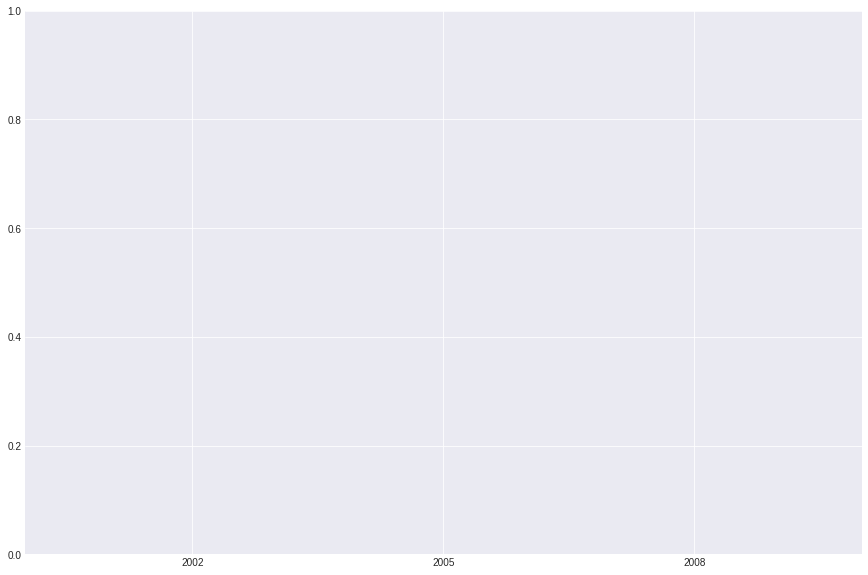

In [187]:
plt.style.use('seaborn-darkgrid')
reload(sn_plotting)

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plotting.temperature_vs_sn_plot(ax,  sn_da.squeeze(), abuprt_da)
#                       temp_highlight = abrupt_stable_da, 
#                       sn_highlight = stable_da)

ax.set_xlim(sn_da.time.values[0], sn_da.time.values[500])
# ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=16);

In [ ]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
for model in models_of_interst:
    da = sn_ds.sel(lat=lat, lon=lon, method='nearest').sel(model=model)['signal_to_noise']
    ax.plot(da.time.values, da.values, label=model)
    
leg = ax.legend(fontsize=12, ncol=3)

KeyError: 'gisse2r'

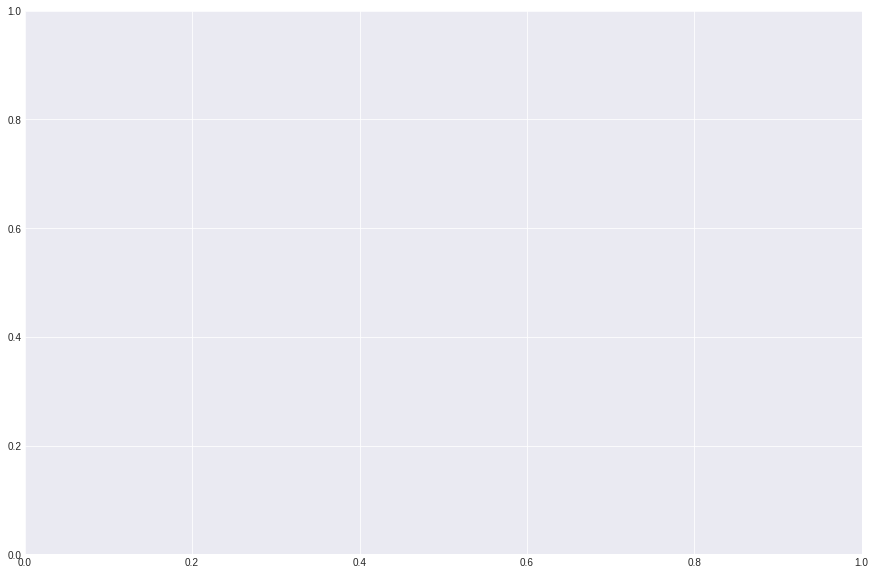

In [132]:
plt.style.use('seaborn-darkgrid')

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
for model in models_of_interst:
    da = abrupt4x_anom_ds[model.lower()].sel(lat=lat, lon=lon, method='nearest')
    da = da.where(da.time.isin(sn_ds.time.values), drop =True)
    ax.plot(da.time.values, da.values, label=model)
    
leg = ax.legend(fontsize=12, ncol=3)

ax.set_xlim(sn_da.time.values[0], sn_da.time.values[500])
# ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=16);

40 74


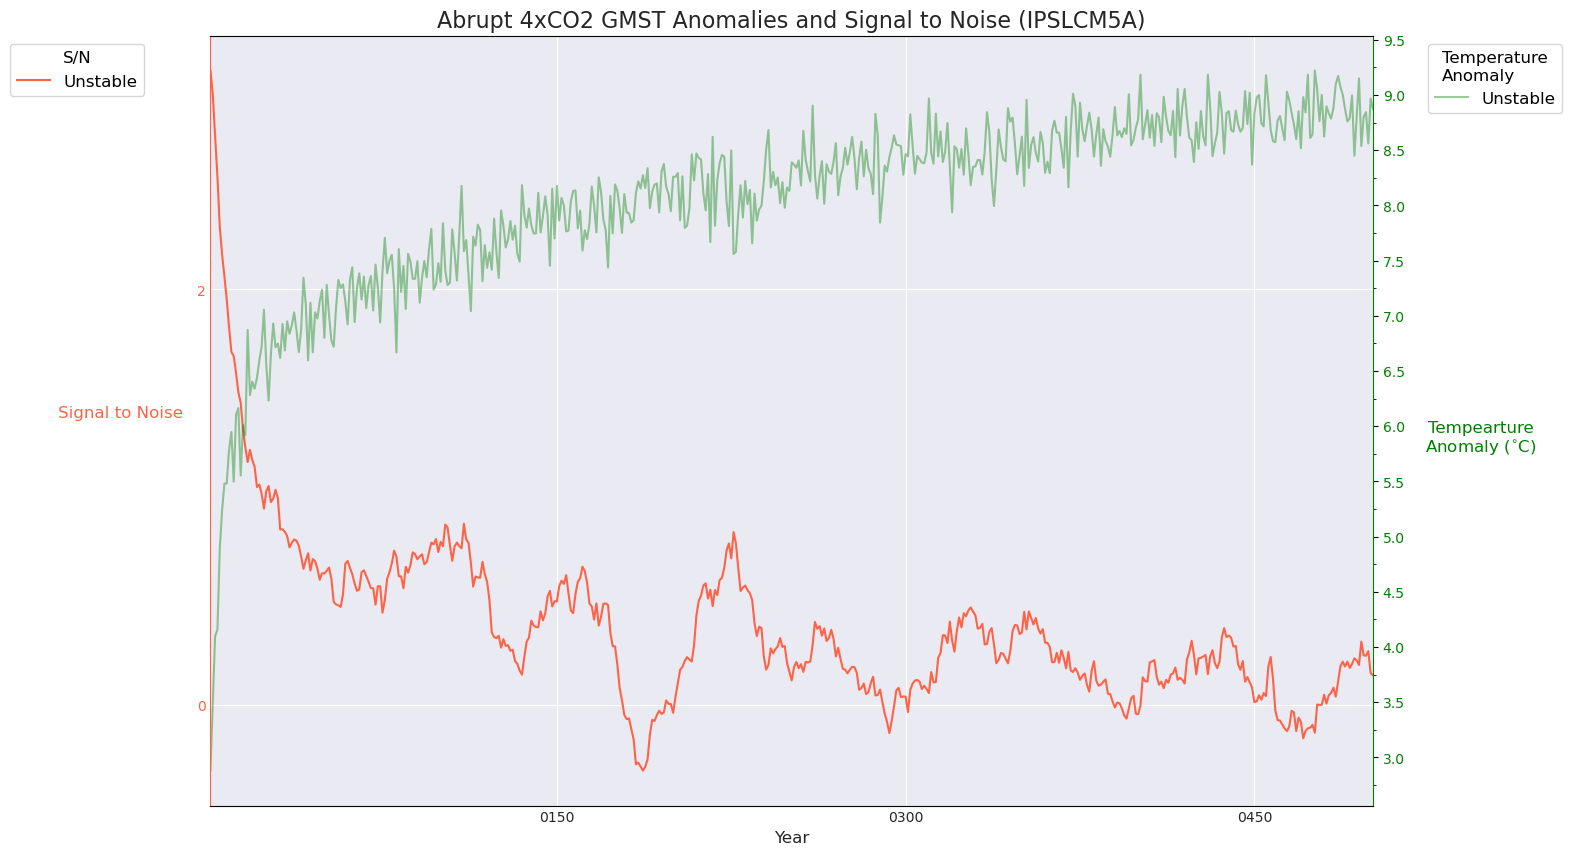

In [111]:

lat,lon = LocationsLatLon.NY.value
print(lat, lon)

sn_mean_da = sn_ds.sel(lat=lat, lon=lon, method='nearest').mean(dim='model')['signal_to_noise']

abuprt_mean_da = (abrupt4x_anom_ds
                  .sel(lat=lat, lon=lon, method='nearest')
                  .to_array(dim='model')
                  .mean(dim='model')
                 )
abuprt_mean_da = abuprt_mean_da.where(abuprt_mean_da.time.isin(sn_ds.time.values), drop =True)

plt.style.use('seaborn-darkgrid')
reload(sn_plotting)

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plotting.temperature_vs_sn_plot(ax,  sn_mean_da, abuprt_mean_da)
#                       temp_highlight = abrupt_stable_da, 
#                       sn_highlight = stable_da)

ax.set_xlim(sn_da.time.values[0], sn_da.time.values[500])
ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=16);

-6.2088 106.84


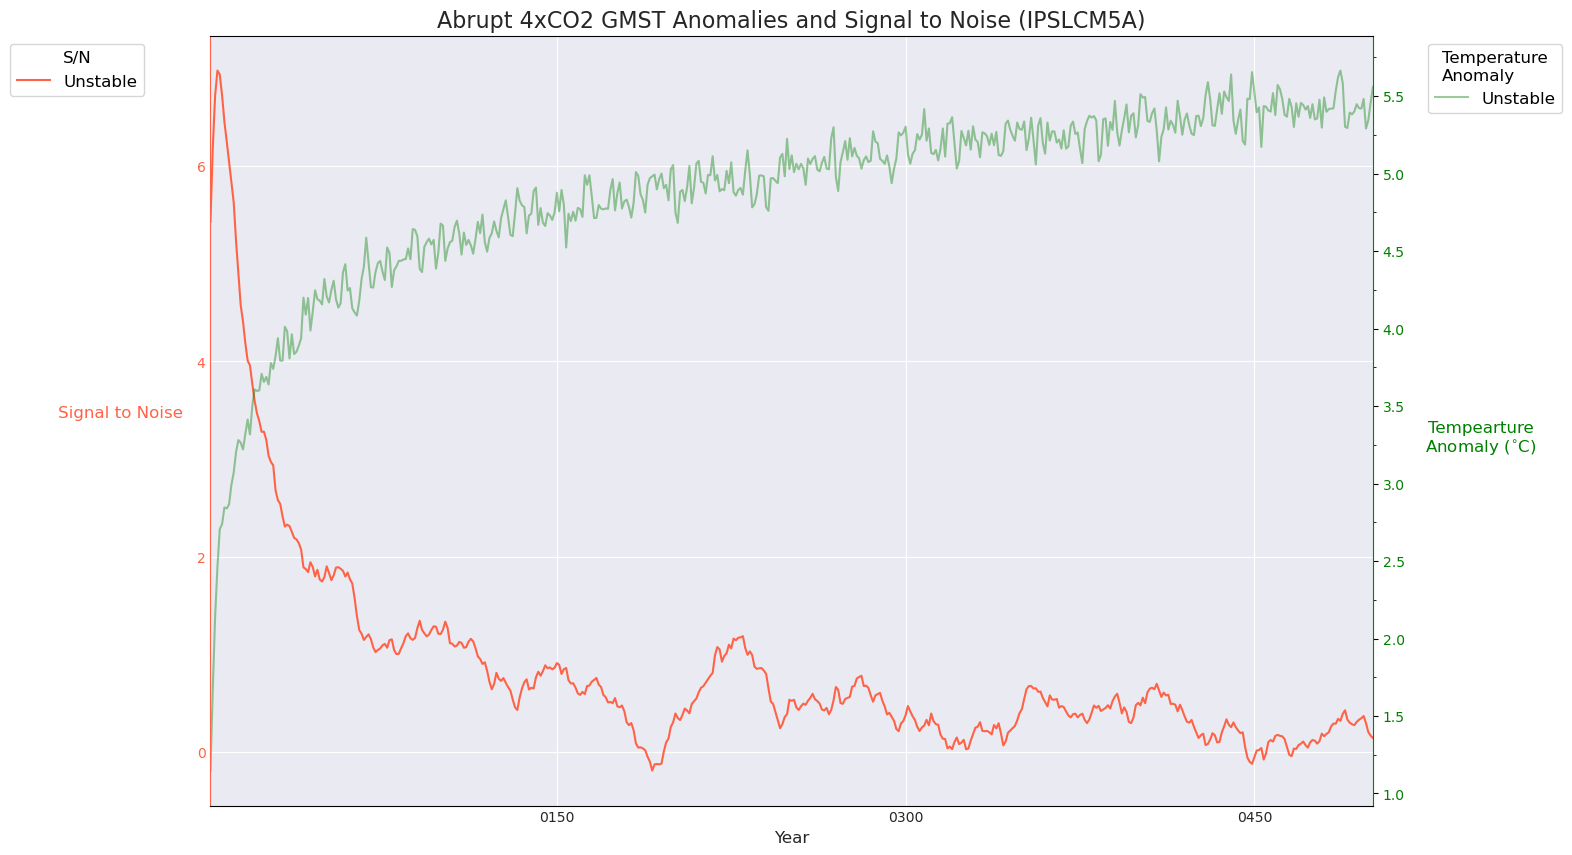

In [112]:

lat,lon = LocationsLatLon.JAKATA.value
print(lat, lon)

sn_mean_da = sn_ds.sel(lat=lat, lon=lon, method='nearest').mean(dim='model')['signal_to_noise']

abuprt_mean_da = (abrupt4x_anom_ds
                  .sel(lat=lat, lon=lon, method='nearest')
                  .to_array(dim='model')
                  .mean(dim='model')
                 )
abuprt_mean_da = abuprt_mean_da.where(abuprt_mean_da.time.isin(sn_ds.time.values), drop =True)

plt.style.use('seaborn-darkgrid')
reload(sn_plotting)

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plotting.temperature_vs_sn_plot(ax,  sn_mean_da, abuprt_mean_da)
#                       temp_highlight = abrupt_stable_da, 
#                       sn_highlight = stable_da)

ax.set_xlim(sn_da.time.values[0], sn_da.time.values[500])
ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=16);

### Single Points

In [113]:
abuprt_anom_ds_2 = xr.concat([abrupt4x_anom_ds[model] for model in abrupt4x_anom_ds.data_vars],
          pd.Index([model.upper() for model in abrupt4x_anom_ds.data_vars], name='model'))
abuprt_anom_ds_2 = abuprt_anom_ds_2.where(abuprt_anom_ds_2.time.isin(stable_ds.time.values), drop=True)
abuprt_anom_ds_2

,Array,Chunk
Bytes,356.67 MiB,648.00 kiB
Shape,"(9, 501, 72, 144)","(1, 8, 72, 144)"
Count,27091 Tasks,567 Chunks
Type,float64,numpy.ndarray


In [114]:
model = 'GISSE2R'

lat,lon = LocationsLatLon.JAKATA.value
print(lat, lon)

sn_da = sn_ds['signal_to_noise'].sel(lat=lat, lon=lon, method='nearest').sel(model=model)
stable_da = stable_ds['signal_to_noise'].sel(lat=lat, lon=lon, method='nearest').sel(model=model)
abuprt_da = abuprt_anom_ds_2.sel(lat=lat, lon=lon, method='nearest').sel(model=model)
abrupt_stable_da = abuprt_da.where(np.isfinite(stable_da))


-6.2088 106.84


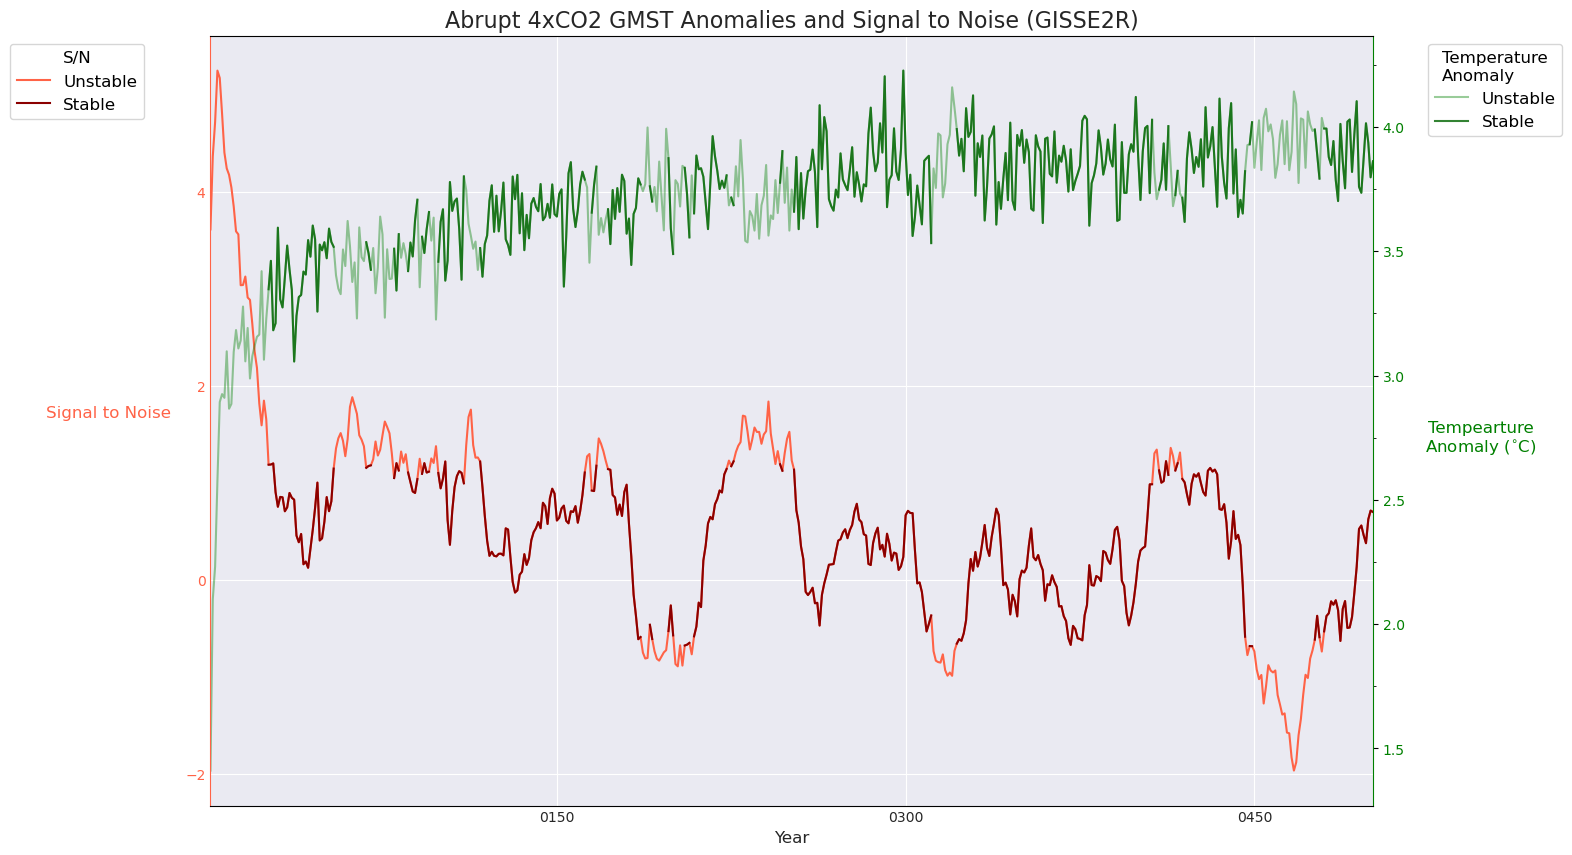

In [115]:
plt.style.use('seaborn-darkgrid')
reload(sn_plotting)

fig = plt.figure(figsize=  (15,10))
ax = fig.add_subplot(111)
sn_plotting.temperature_vs_sn_plot(ax,  sn_da, abuprt_da,
                      temp_highlight = abrupt_stable_da, 
                      sn_highlight = stable_da)

ax.set_xlim(sn_da.time.values[0], sn_da.time.values[500])
ax.set_title(f'Abrupt 4xCO2 GMST Anomalies and Signal to Noise ({model})', fontsize=16);

# fig.savefig(f'{IMG_DIR}/02_{model}_global_sn_temp_anomaly_t500.png', bbox_inches='tight', dpi=200)